<a href="https://colab.research.google.com/github/denis201520182022/colorization-project/blob/main/Image_Colorization_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch torchvision matplotlib opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.5 MB/s eta 0:00:00


In [3]:
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Размер картинки: torch.Size([3, 64, 64])
Тип тензора: <class 'torch.Tensor'>


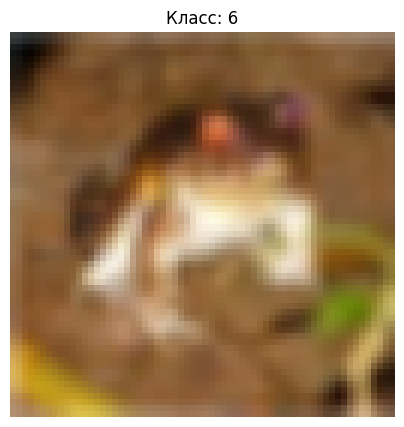

In [9]:
import matplotlib.pyplot as plt
import torch

img, label = train_dataset[0]

print("Размер картинки:", img.shape)
print("Тип тензора:", type(img))

plt.figure(figsize=(5,5))
plt.imshow(img.permute(1,2,0))
plt.title(f'Класс: {label}')
plt.axis('off')
plt.show()

In [10]:
def rgb_to_grayscale(img):
  r,g,b = img[0], img[1], img[2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray.unsqueeze(0)

Цветное изображение: torch.Size([3, 64, 64])
Серое изображение: torch.Size([1, 64, 64])


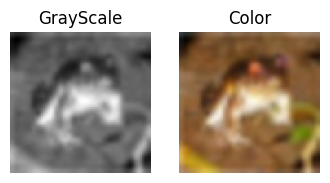

In [13]:
img_color, _ = train_dataset[0]
img_gray = rgb_to_grayscale(img_color)

print('Цветное изображение:', img_color.shape)
print('Серое изображение:', img_gray.shape)

plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(img_gray.squeeze(0), cmap='gray')
plt.title('GrayScale')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_color.permute(1,2,0))
plt.title('Color')
plt.axis('off')

plt.show()

In [48]:
from torch.utils.data import Dataset

class ColorizationDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img_color, _ = self.dataset[idx]
    img_gray = rgb_to_grayscale(img_color)  # Преобразуем в серое изображение

    # Добавляем размерность канала (делаем изображение [1, 64, 64])
    img_gray = img_gray.unsqueeze(0)  # Размерность станет [1, 64, 64], т.е. 1 канал
    return img_gray, img_color




torch.Size([1, 64, 64])
torch.Size([3, 64, 64])


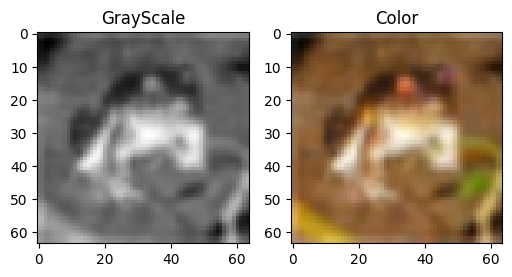

In [45]:
colorization_dataset = ColorizationDataset(train_dataset)

img_gray, img_color = colorization_dataset[0]
print(img_gray.shape)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_gray.squeeze(0), cmap='gray')
plt.title('GrayScale')
print(img_color.shape)
plt.subplot(1,2,2)
plt.imshow(img_color.permute(1,2,0))
plt.title('Color')
plt.show()

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [62]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Энкодер: сжимаем информацию
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # [1, 64, 64] -> [32, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> [32, 32, 32]

            nn.Conv2d(32, 64, 3, padding=1), # -> [64, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> [64, 16, 16]
        )

        # Декодер: восстанавливаем цвета
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, padding=1, stride=2, output_padding=1),  # -> [64, 16, 16] -> [64, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1),  # -> [32, 32, 32] -> [32, 64, 64]
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),  # -> [3, 64, 64]
            nn.Sigmoid()  # чтобы значения были от 0 до 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [67]:
model = ColorizationNet()


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [69]:
import torch.optim as optim

num_epochs = 10
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [70]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (gray_img, color_img) in enumerate(colorization_dataset):  # используем colorization_dataset
        gray_img = gray_img.to(device).float()  # Получаем градации серого (1 канал)
        color_img = color_img.to(device).float()  # Получаем цветное изображение (3 канала)

        optimizer.zero_grad()

        # Пропускаем через модель
        outputs = model(gray_img)  # Размерность: [batch_size, 3, 64, 64]

        # Проверим размерности


        # Считаем ошибку (MSELoss, так как это регрессия для пикселей)
        loss = criterion(outputs, color_img)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(colorization_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")



Epoch [1/10], Loss: 0.0062
Epoch [2/10], Loss: 0.0058
Epoch [3/10], Loss: 0.0057
Epoch [4/10], Loss: 0.0056
Epoch [5/10], Loss: 0.0056
Epoch [6/10], Loss: 0.0056
Epoch [7/10], Loss: 0.0056
Epoch [8/10], Loss: 0.0055
Epoch [9/10], Loss: 0.0055
Epoch [10/10], Loss: 0.0055


In [73]:

torch.save(model.state_dict(), 'colorization_model.pth')
torch.save(model, 'colorization_model_full.pth')

from google.colab import files
files.download('colorization_model.pth')
files.download('colorization_model_full.pth')







<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
colorization_dataset_test = ColorizationDataset(test_dataset)

# Оценка качества модели на тестовой выборке
model.eval()  # Устанавливаем модель в режим оценки
test_loss = 0.0

with torch.no_grad():  # Отключаем градиенты, так как мы только оцениваем
    for gray_img, color_img in colorization_dataset_test:
        if gray_img.shape[1] == 3:
          gray_img = 0.299 * gray_img[:,0:1,:,:] + 0.587 * gray_img[:,1:2,:,:] + 0.114 * gray_img[:,2:3,:,:]
        gray_img = gray_img.to(device).float()
        color_img = color_img.to(device).float()

        outputs = model(gray_img)  # Предсказания модели

        loss = criterion(outputs, color_img)  # Вычисляем ошибку

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {average_test_loss:.4f}')

Test Loss: 0.1752


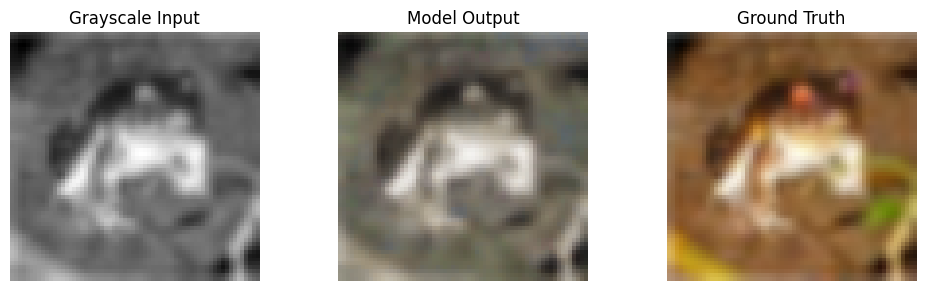

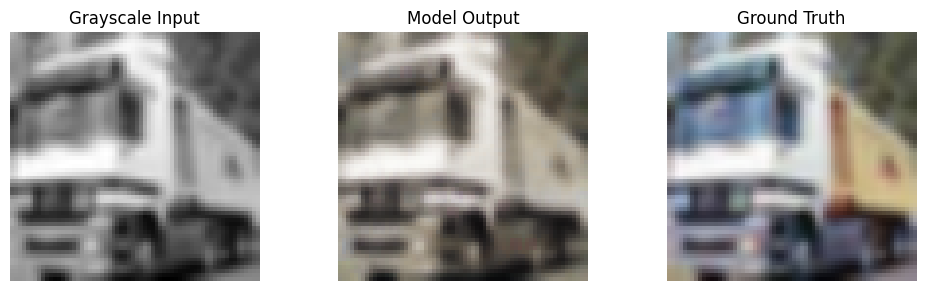

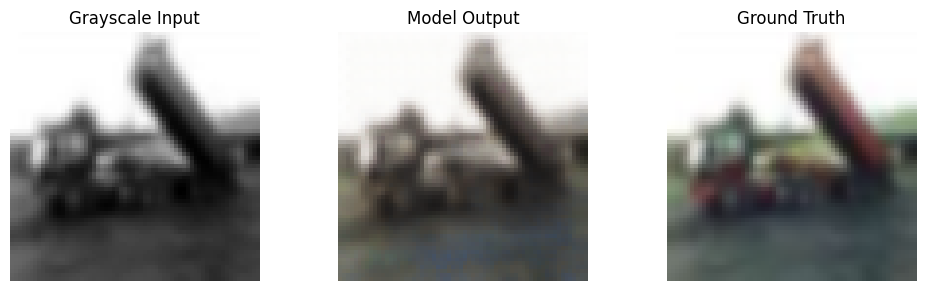

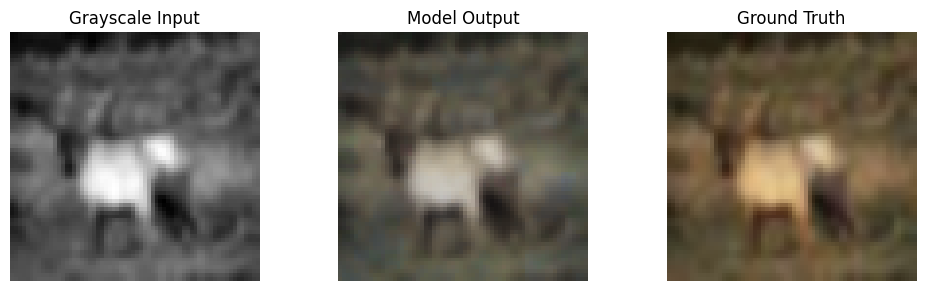

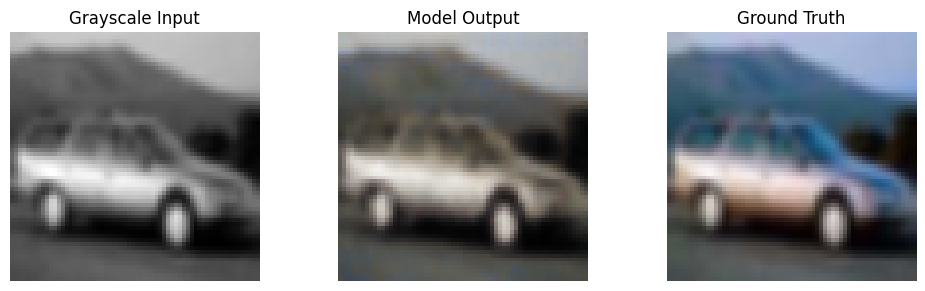

In [72]:
import matplotlib.pyplot as plt

# Перевод модели в режим eval
model.eval()

# Выбираем N случайных изображений из тестового набора
num_images = 5
for i in range(num_images):
    gray_img, color_img = colorization_dataset[i]  # берём из кастомного датасета
    input_tensor = gray_img.unsqueeze(0).to(device)  # добавляем батч-дименсию

    with torch.no_grad():
        output = model(input_tensor).cpu().squeeze(0)  # убираем батч

    # Переводим тензоры обратно в изображение
    gray_np = gray_img.squeeze(0).numpy()
    pred_np = output.permute(1, 2, 0).numpy()
    true_np = color_img.permute(1, 2, 0).numpy()

    # Визуализация
    plt.figure(figsize=(10,3))

    plt.subplot(1,3,1)
    plt.imshow(gray_np, cmap='gray')
    plt.title('Grayscale Input')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(pred_np)
    plt.title('Model Output')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(true_np)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
